In [1]:
from PIL import Image
import os
import pickle
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [2]:
def adaptive_histeq(img_gray):
      clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
      final_img = clahe.apply(img_gray) 
      return final_img

In [3]:
def simple_processing_clahe(img):
    
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    kernel = cv2.getStructuringElement(1,(7,7))
    closing = cv2.morphologyEx(gray,cv2.MORPH_CLOSE,kernel, iterations = 2)
    imgeq = cv2.equalizeHist(gray)
    clahe=adaptive_histeq(gray)
    
    return clahe
    

In [4]:
def preprocessing_lab_histeq(img):
        blur = cv2.GaussianBlur(img,(5,5),0)
        
        
        # https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
        lab= cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l_channel)
        limg = cv2.merge((cl,a,b))
        enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
        #enhanced_img = cv2.convertScaleAbs(enhanced_img, alpha=1.3, beta=-40)

        
        gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY )
        gray=cv2.equalizeHist(gray)
        
        #gray = cv2.GaussianBlur(gray,(5,5),0)
        
        return gray

In [5]:
def preprocessing_enhance_thresh(img):
     # Step 1
        blur = cv2.GaussianBlur(img,(13,13),0)
        
        
        # Step 3
        # https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
#         lab= cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
#         l_channel, a, b = cv2.split(lab)
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         cl = clahe.apply(l_channel)
#         limg = cv2.merge((cl,a,b))
#         enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        enhanced_img = cv2.convertScaleAbs(blur, alpha=1.8, beta=10)

        # Step 4
        gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY )
        gray=cv2.equalizeHist(gray)
        edges = cv2.Canny(gray,0,255)
        
        edges_inverse = cv2.bitwise_not(edges)
        

            
        # Step 5
        
        T,imgt = cv2.threshold(gray,np.median(gray)-1,255,cv2.THRESH_BINARY)

    
        return gray

In [6]:
def hsv_histeq(img_gray):
    value=90
    bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    imgeq=cv2.equalizeHist(v)

    final_hsv = cv2.merge((h, s, imgeq))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [7]:
# https://github.com/sunnyshah2894/DigitalHairRemoval

def remove_hairs(img):
    kernel = cv2.getStructuringElement(1,(17,17))
    grayScale = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    edges = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    ret,thresh = cv2.threshold(edges,10,255,cv2.THRESH_BINARY)
    dst = cv2.inpaint(img,thresh,1,cv2.INPAINT_TELEA)
    
    return edges, thresh, dst

In [8]:
def normalize_red_band(img):
    blank_img = img
    linhas,colunas,channels=img.shape
    for l in range(linhas):
          for c in range(colunas):
                ur,ug,ub = img[l][c]
                norm = ur/math.sqrt(ur**2+ug**2+ub**2)
                blank_img[l][c] = (norm,ug,ub)
    
    return blank_img

In [9]:
def preprocessing_hair_rnorm_histeq(img):

        edges, thresh, dst = remove_hairs(img)
        r_norm = normalize_red_band(dst)
        gray = cv2.cvtColor( r_norm, cv2.COLOR_RGB2GRAY )
        imgeq = hsv_histeq(gray)
        
        return imgeq
        

In [17]:
SOURCE_DIRECTORY = "../../data/images"
for f in os.listdir(SOURCE_DIRECTORY):
    if f.endswith(".png"):
        print(f)

PAT_1000_31_620.png
PAT_1006_53_385.png
PAT_1006_53_716.png
PAT_1008_59_297.png
PAT_100_393_595.png
PAT_100_393_898.png
PAT_1013_82_876.png
PAT_1014_85_22.png
PAT_1014_86_861.png
PAT_1017_97_577.png
PAT_1018_107_68.png
PAT_1019_110_194.png
PAT_101_1041_651.png
PAT_101_1041_658.png
PAT_101_1041_898.png
PAT_1020_111_593.png
PAT_1021_112_40.png
PAT_1022_114_756.png
PAT_1022_115_132.png
PAT_1026_124_206.png
PAT_1026_124_346.png
PAT_1027_128_854.png
PAT_1029_135_239.png
PAT_1029_135_983.png
PAT_1031_148_29.png
PAT_1031_148_292.png
PAT_1031_148_66.png
PAT_1033_153_301.png
PAT_1034_160_819.png
PAT_1034_161_203.png
PAT_1035_165_800.png
PAT_1036_169_687.png
PAT_1042_187_746.png
PAT_1046_203_511.png
PAT_104_1754_276.png
PAT_104_1755_320.png
PAT_104_1756_151.png
PAT_1051_220_356.png
PAT_1057_242_297.png
PAT_1061_254_813.png
PAT_1062_264_741.png
PAT_1063_268_704.png
PAT_1063_268_919.png
PAT_1063_269_755.png
PAT_1063_270_593.png
PAT_1063_271_448.png
PAT_1064_272_668.png
PAT_1064_273_980.png
PAT_106

PAT_314_672_909.png
PAT_315_673_227.png
PAT_316_1457_353.png
PAT_316_674_318.png
PAT_316_674_924.png
PAT_317_675_144.png
PAT_318_677_278.png
PAT_319_678_357.png
PAT_319_679_533.png
PAT_319_680_166.png
PAT_319_680_832.png
PAT_31_42_680.png
PAT_31_43_129.png
PAT_320_681_410.png
PAT_320_681_724.png
PAT_321_682_236.png
PAT_323_686_356.png
PAT_323_687_169.png
PAT_324_1464_266.png
PAT_324_1465_43.png
PAT_325_1506_440.png
PAT_325_1506_999.png
PAT_325_689_528.png
PAT_326_690_797.png
PAT_326_690_823.png
PAT_328_1738_890.png
PAT_328_692_681.png
PAT_32_44_211.png
PAT_330_1437_458.png
PAT_330_1437_506.png
PAT_330_1438_323.png
PAT_330_1440_532.png
PAT_330_695_296.png
PAT_330_695_90.png
PAT_330_696_894.png
PAT_330_697_575.png
PAT_330_698_211.png
PAT_330_698_302.png
PAT_333_1468_620.png
PAT_333_1469_499.png
PAT_333_702_840.png
PAT_334_703_907.png
PAT_336_705_711.png
PAT_337_1697_721.png
PAT_337_706_254.png
PAT_337_706_598.png
PAT_337_706_944.png
PAT_338_707_774.png
PAT_338_709_306.png
PAT_338_710_319

In [10]:
SOURCE_DIRECTORY = "../../data/images"

def apply_preprocessing(src_dir, dest_dir, func):
    imgs_list = []
    with open(dest_dir,"wb") as dest:
        for f in os.listdir(src_dir):
            if f.endswith(".png"):
                filename = '../../data/images/'+f
                img = cv2.imread(filename)[:,:,::-1]
                processed = func(img)
                imgs_list.append(processed)
                
        pickle.dump(imgs_list,dest)

            
            
    

In [ ]:
pickle_file = "../../data/images/preprocessing_1.pickle"
apply_preprocessing(SOURCE_DIRECTORY, pickle_file, simple_processing_clahe)        


In [62]:
pickle_file = "../../data/images/preprocessing_2.pickle"
apply_preprocessing(SOURCE_DIRECTORY, pickle_file, preprocessing_lab_histeq)        

In [63]:
pickle_file = "../../data/images/preprocessing_3.pickle"
apply_preprocessing(SOURCE_DIRECTORY, pickle_file, preprocessing_enhance_thresh)        

In [ ]:
pickle_file = "../../data/images/preprocessing_4.pickle"
apply_preprocessing(SOURCE_DIRECTORY, pickle_file, preprocessing_hair_rnorm_histeq)        

2300


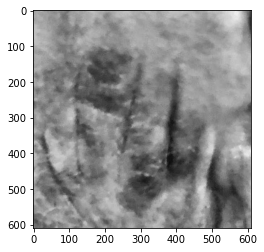

In [11]:

# # test that we can reread the list

recovered_list = pickle.load(open(PICKLE_FILE,"rb"))
print(len(recovered_list))
# # read a couple images out of the image file:

display_count = 1

# for img in recovered_list:


with open(PICKLE_FILE,"rb") as f:
        try:
            recovered_list = pickle.load(f)
        except:
            apply_preprocessing(SOURCE_DIRECTORY, pickle_file, preprocessing_hair_rnorm_histeq)        
            
plt.imshow(recovered_list[0], cmap='gray', vmin = 0, vmax = 255)


In [50]:
recovered_list[0].shape

(609, 609)